In [1]:
import numpy.random as nr
import pandas as pd
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

### Read Data Frame

In [2]:
df = pd.read_csv('data/Dummy-Data.csv')
df.head()

,AppID,Ins_Age,Ins_Gender,Ht,Wt,IssueDate
0,56372,31,Male,510,185,NaN
1,34565,35,Male,510,205,NaN
2,57732,45,Female,510,125,NaN
3,87324,38,Male,503,175,NaN
4,12323,39,Female,600,252,NaN


### Convert Weight to Kg from Pounds

In [3]:
ground_truth_df = df
ground_truth_df['Wt_kg'] = 0.453592*df['Wt']
ground_truth_df.head()

,AppID,Ins_Age,Ins_Gender,Ht,Wt,IssueDate,Wt_kg
0,56372,31,Male,510,185,NaN,83.914520
1,34565,35,Male,510,205,NaN,92.986360
2,57732,45,Female,510,125,NaN,56.699000
3,87324,38,Male,503,175,NaN,79.378600
4,12323,39,Female,600,252,NaN,114.305184


### Convert Height from feet to metre

In [4]:
ground_truth_df['Ht_modified'] = (ground_truth_df['Ht']/100).astype(str)
ground_truth_df[['Ht_ft', 'Ht_in']] = ground_truth_df['Ht_modified'].str.split('.', 1, expand=True)
ground_truth_df['Ht_ft'] = ground_truth_df['Ht_ft'].astype(int)
ground_truth_df['Ht_in'] = ground_truth_df['Ht_in'].astype(int)
ground_truth_df['Ht_m'] = ground_truth_df['Ht_ft']*0.3048 + ground_truth_df['Ht_in']*0.0254
ground_truth_df.head()

,AppID,Ins_Age,Ins_Gender,Ht,Wt,IssueDate,Wt_kg,Ht_modified,Ht_ft,Ht_in,Ht_m
0,56372,31,Male,510,185,NaN,83.914520,5.1,5,1,1.5494
1,34565,35,Male,510,205,NaN,92.986360,5.1,5,1,1.5494
2,57732,45,Female,510,125,NaN,56.699000,5.1,5,1,1.5494
3,87324,38,Male,503,175,NaN,79.378600,5.03,5,3,1.6002
4,12323,39,Female,600,252,NaN,114.305184,6.0,6,0,1.8288


### Calcucalte BMI and prepare dataframe for ground truth

In [5]:
ground_truth_df['BMI'] = ground_truth_df['Wt_kg']/(ground_truth_df['Ht_m']**2)
ground_truth_df = ground_truth_df.drop(['AppID', 'Ht', 'Wt', 'IssueDate', 'Ht_modified', 'Ht_ft', 'Ht_in'], axis=1)
ground_truth_df.head()

,Ins_Age,Ins_Gender,Wt_kg,Ht_m,BMI
0,31,Male,83.914520,1.5494,34.955057
1,35,Male,92.986360,1.5494,38.733982
2,45,Female,56.699000,1.5494,23.618282
3,38,Male,79.378600,1.6002,30.999515
4,39,Female,114.305184,1.8288,34.176966


### Split Data into test and train

In [6]:
RANDOM_SEED = 123
VAL_SIZE = 0.15
TEST_SIZE = 0.15
SCORING = 'r2'
K_CROSS_VAL = 5

In [7]:
train, test = train_test_split(ground_truth_df, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [8]:
print(train.shape)
train.head()

(85, 5)


,Ins_Age,Ins_Gender,Wt_kg,Ht_m,BMI
42,19,Female,81.64656,1.8034,25.104626
77,36,Female,77.11064,1.7526,25.104333
38,46,Female,54.43104,1.6764,19.368292
56,24,Male,81.64656,1.9304,21.910045
75,47,Male,81.64656,1.7018,28.191673


In [9]:
print(test.shape)
test.head()

(15, 5)


,Ins_Age,Ins_Gender,Wt_kg,Ht_m,BMI
8,40,Female,70.30676,1.8288,21.021546
70,37,Male,72.57472,1.6764,25.824390
82,36,Male,63.50288,1.5748,25.606051
28,19,Female,77.11064,1.8542,22.428548
63,21,Male,72.57472,1.6002,28.342414


### Scale Continous features

In [10]:
continous_features = ['Ht_m', 'Wt_kg']
scaler = StandardScaler()
scaler.fit(train[continous_features])
train[continous_features] = scaler.transform(train[continous_features])
test[continous_features] = scaler.transform(test[continous_features])
train.head()

C:\Users\mzrwlw\Anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\Users\mzrwlw\Anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,Ins_Age,Ins_Gender,Wt_kg,Ht_m,BMI
42,19,Female,0.576398,0.879392,25.104626
77,36,Female,0.205794,0.440985,25.104333
38,46,Female,-1.647224,-0.216624,19.368292
56,24,Male,0.576398,1.975408,21.910045
75,47,Male,0.576398,0.002579,28.191673


In [11]:
test.head()

,Ins_Age,Ins_Gender,Wt_kg,Ht_m,BMI
8,40,Female,-0.350111,1.098595,21.021546
70,37,Male,-0.164810,-0.216624,25.824390
82,36,Male,-0.906017,-1.093437,25.606051
28,19,Female,0.205794,1.317798,22.428548
63,21,Male,-0.164810,-0.874234,28.342414


### Input Feature Distributions

<AxesSubplot:>

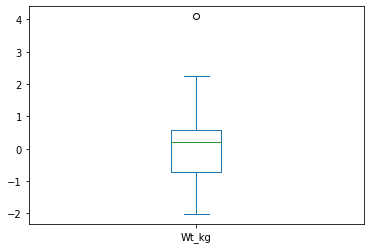

In [12]:
train['Wt_kg'].plot.box()

<AxesSubplot:>

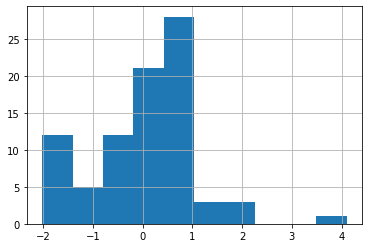

In [13]:
train['Wt_kg'].hist()

<AxesSubplot:>

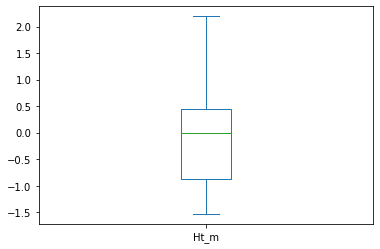

In [14]:
train['Ht_m'].plot.box()

<AxesSubplot:>

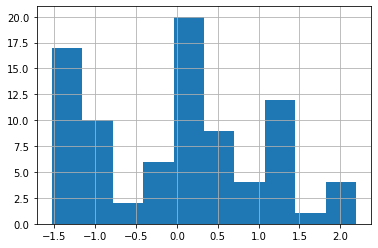

In [15]:
train['Ht_m'].hist()

### Evaluate models using cross validation and also calculate test dataset score

In [16]:
lin_regressor = LinearRegression()
score_arr = cross_val_score(lin_regressor,
                            train[continous_features],
                            train['BMI'],
                            cv=K_CROSS_VAL,
                            scoring=SCORING)
print(f'R2 across {K_CROSS_VAL} score arr {score_arr}')
print(f'Avg R2 for cross validation: {sum(score_arr)/K_CROSS_VAL}')
lin_regressor = LinearRegression().fit(train[continous_features], train['BMI'])
y_pred = lin_regressor.predict(test[continous_features])
r2_test = r2_score(test['BMI'], y_pred)
print(f'R2 for test set {r2_test}')

R2 across 5 score arr [0.98736258 0.97255642 0.98273183 0.98547715 0.9708301 ]
Avg R2 for cross validation: 0.979791618808078
R2 for test set 0.96820093242257


In [17]:
svm_regressor = SVR(kernel = 'rbf')
score_arr = cross_val_score(svm_regressor,
                            train[continous_features],
                            train['BMI'],
                            cv=K_CROSS_VAL,
                            scoring=SCORING)
print(f'R2 across {K_CROSS_VAL} score arr {score_arr}')
print(f'Avg R2: {sum(score_arr)/K_CROSS_VAL}')
svm_regressor = SVR().fit(train[continous_features], train['BMI'])
y_pred = svm_regressor.predict(test[continous_features])
r2_test = r2_score(test['BMI'], y_pred)
print(f'R2 for test set {r2_test}')

R2 across 5 score arr [0.96710477 0.19853876 0.87052928 0.95072015 0.8721909 ]
Avg R2: 0.7718167720548602
R2 for test set 0.8143370757933495


### Looking at above celss, Linear Regression seems to be outperforming SVR.

### Save Model and Scaler as pickles for offline usage

In [18]:
LIN_REG_MODEL_PATH = 'models/linear_reg.pickle'
SCALER_PATH = 'models/scaler.pickle'
WRITE_MODE = 'wb'
pickle.dump(lin_regressor, open(LIN_REG_MODEL_PATH, WRITE_MODE))
pickle.dump(scaler, open(SCALER_PATH, WRITE_MODE))

### Check whether pickle work correctly for inference or not

In [19]:
READ_MODE = 'rb'
loaded_model = pickle.load(open(LIN_REG_MODEL_PATH, READ_MODE))
loaded_scaler = pickle.load(open(SCALER_PATH, READ_MODE))

my_weight_kg = 78
my_height_m = 1.76

df = pd.DataFrame({'Ht_m': [my_height_m], 'Wt_kg': [my_weight_kg]})
df_scaled = loaded_scaler.transform(df)
BMI_pred = loaded_model.predict(df_scaled).tolist()[0]
print(f'Predicted BMI: {BMI_pred}')
BMI_original = (my_weight_kg)/(my_height_m**2)
print(f'Original BMI: {BMI_original}')

Predicted BMI: 25.612659938528836
Original BMI: 25.180785123966942
